# Using RNNs to predict time series

In the previous Notebook we used a vanilla deep neural network to create forecasts for generated time series. This time we will be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs to see how these two approaches compare.

Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

We will be generating the same time series data as before.

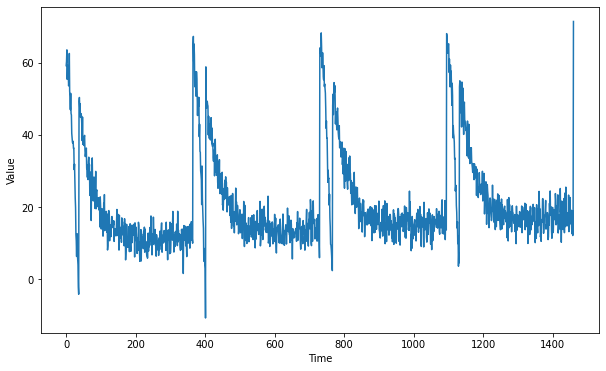

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

In [18]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [19]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Defining the model architecture

Now that we have a function that will process the data before it is fed into our neural network for training, it is time to define the layer architecture. Unlike previous Notebooks, here we will first define the `create_uncompiled_model` function below. 

This is done so we can reuse your model's layers for the learning rate adjusting and the actual training.

In [6]:
def create_uncompiled_model():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 

    return model

In [7]:
# Test uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

34/34 [==============================] - 3s 40ms/step
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [8]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    # Select optimizer
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
        
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [9]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 6s 13ms/step - loss: 62.4777 - mae: 62.9777 - lr: 1.0000e-06
Epoch 2/100
34/34 [==============================] - 1s 12ms/step - loss: 61.2787 - mae: 61.7787 - lr: 1.1220e-06
Epoch 3/100
34/34 [==============================] - 0s 11ms/step - loss: 59.9355 - mae: 60.4355 - lr: 1.2589e-06
Epoch 4/100
34/34 [==============================] - 1s 12ms/step - loss: 58.4319 - mae: 58.9318 - lr: 1.4125e-06
Epoch 5/100
34/34 [==============================] - 1s 12ms/step - loss: 56.7499 - mae: 57.2498 - lr: 1.5849e-06
Epoch 6/100
34/34 [==============================] - 1s 12ms/step - loss: 54.8673 - mae: 55.3673 - lr: 1.7783e-06
Epoch 7/100
34/34 [==============================] - 1s 12ms/step - loss: 52.7601 - mae: 53.2601 - lr: 1.9953e-06
Epoch 8/100
34/34 [==============================] - 1s 12ms/step - loss: 50.3976 - mae: 50.8976 - lr: 2.2387e-06
Epoch 9/100
34/34 [==============================] - 1s 12ms/step - loss: 47.7490 - mae:

(1e-06, 1.0, 0.0, 30.0)

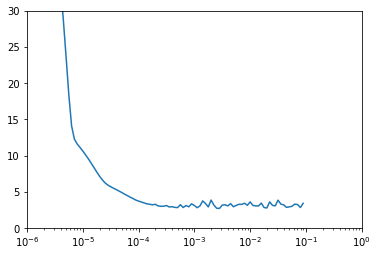

In [10]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Compiling the model

Now that we have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that we are reusing the architecture we defined in the `create_uncompiled_model` earlier. Now we only need to compile this model using the appropriate loss, optimizer (and learning rate).

In [20]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mae"])  

    return model

In [12]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 8s 14ms/step - loss: 9.9907 - mae: 10.4752
Epoch 2/50
34/34 [==============================] - 1s 16ms/step - loss: 4.0080 - mae: 4.4739
Epoch 3/50
34/34 [==============================] - 0s 12ms/step - loss: 3.2409 - mae: 3.7065
Epoch 4/50
34/34 [==============================] - 1s 12ms/step - loss: 3.2430 - mae: 3.7127
Epoch 5/50
34/34 [==============================] - 1s 12ms/step - loss: 2.8710 - mae: 3.3376
Epoch 6/50
34/34 [==============================] - 1s 12ms/step - loss: 2.7231 - mae: 3.1836
Epoch 7/50
34/34 [==============================] - 1s 12ms/step - loss: 2.9418 - mae: 3.3984
Epoch 8/50
34/34 [==============================] - 1s 12ms/step - loss: 2.7413 - mae: 3.2049
Epoch 9/50
34/34 [==============================] - 1s 12ms/step - loss: 3.0174 - mae: 3.4857
Epoch 10/50
34/34 [==============================] - 1s 12ms/step - loss: 2.9159 - mae: 3.3780
Epoch 11/50
34/34 [==============================] - 1s 12

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function that we coded before:

In [13]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast. 

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

46/46 [==============================] - 2s 8ms/step


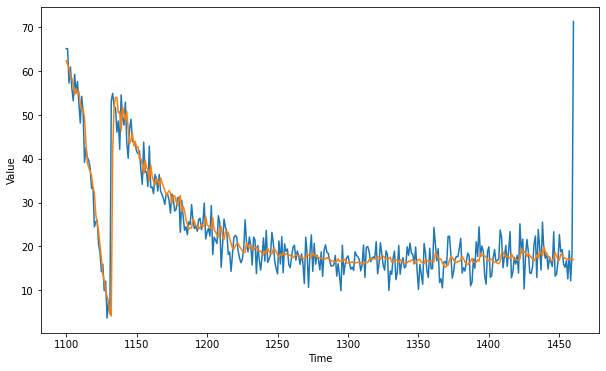

In [15]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 26.99, mae: 3.03 for forecast


**The forecast should achieve an MAE of 4.5 or less (which it does).**

In [ ]:
# Save the model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

**Finish**

We have successfully implemented a neural network capable of forecasting time series leveraging Tensorflow's layers for sequence modelling such as `RNNs` and `LSTMs`! 

Links:
* DeepLearning.ai Assignment: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/programming/30QuE/forecast-using-rnns-or-lstms